In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import itertools
from tqdm import tqdm, trange

from agents.dqn import DoubleDQNAgent, QNetwork
from env import GridEnvDeform, POMDPWrapper_v0, create_maze
import matplotlib.pyplot as plt



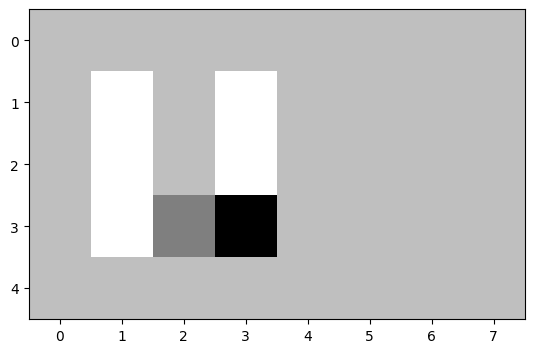

States: 144, Actions: 4, Observations 32, Thetas [(1, 1), (2, 1)]



In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 3
l1 = 1
h1 = 2

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenA = len(actions)
lenO = len(obs)

print(f"States: {lenS}, Actions: {lenA}, Observations {lenO}, Thetas {thetas}\n")

T = torch.load(f"models/T_maze_{N}.pt", weights_only=True)
R = torch.load(f"models/R_maze_{N}.pt", weights_only=True)
O = torch.load(f"models/O_maze_{N}.pt", weights_only=True)


# fully observable train

notice that the train is fully observable, in the following cell each transition is \
(1) the current state \
(2) the action taken \
(3) the reward received \
(4) the next state \
(5) the done flag

where current state is an int (range(0, len(states)))

# tabular q-learning

In [9]:
# from agents.tabular_qlearning import q_learning

# Q = q_learning(env, 10000, 0.1, 0.9, 0.5, states_dict=state_dict)

# np.save(f"agents/tabularQ_maze_{N}.npy", Q)

Q = np.load(f"agents/tabularQ_maze_{N}.npy")

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -6.88996568,  -7.99817568,  -9.06731416,
        -14.26667888, -13.55522795, -11.29367114,   0.        ],
       [  0.        ,  -5.82295409,  -3.51197801, -10.24467562,
        -14.94129718, -13.6366324 , -12.39203609,   0.        ],
       [  0.        ,  -4.92616118,   0.990713  ,   3.66767523,
        -13.63890276, -13.51963595, -11.13700941,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

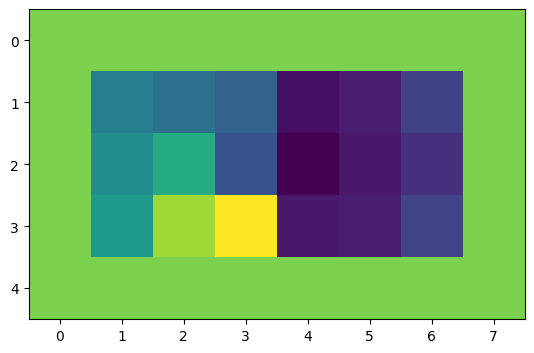

In [10]:
# state_value = torch.zeros(lenS)
# for s in range(lenS):
#     state_value[s] = np.max(Q[s])

state_value = np.max(Q,axis=1)


Value_matrix_plot = np.zeros(env.maze.shape)
for s, state in enumerate(states):
    # print(f"State: {state}, Value: {state_value[s]}")
    if state[1] == (1,1):
        Value_matrix_plot[state[0][0],state[0][1]] = state_value[s]

# plot the value function as matrix
plt.imshow(Value_matrix_plot)
Value_matrix_plot


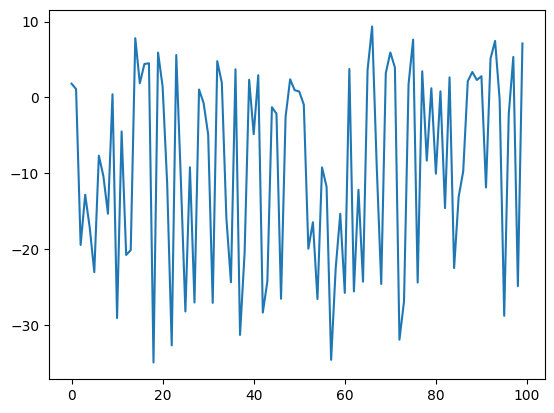

In [11]:
def eval_tabular(env : GridEnvDeform, Q, num_episodes=100):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = state_dict[s]

        episode_reward = 0
        done = False
        c = 25
        while c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = np.argmax(Q[state])
            next_state, reward, done, _, info = env.step(action.item(),s)
            state = state_dict[next_state]


            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [eval_tabular(env, Q, 10) for _ in range(100)]   
plt.plot(rewards)

In [12]:
eval_tabular(env, Q, 1000)

np.float64(-2.651861528412802)

## train Q network to approximate the tabular Q function

In [13]:
model = QNetwork(5, 4)
epochs = 100
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.MSELoss()


Q = torch.tensor(Q,dtype=torch.float32)

# train the model
for epoch in range(epochs):
    for s, y in zip(states, Q[:]):
        x = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}')    


Epoch 0 loss: 35.36020278930664
Epoch 5 loss: 44.67377853393555
Epoch 10 loss: 72.80535888671875
Epoch 15 loss: 81.21187591552734
Epoch 20 loss: 61.700401306152344
Epoch 25 loss: 48.02880096435547
Epoch 30 loss: 45.27069091796875
Epoch 35 loss: 42.943817138671875
Epoch 40 loss: 38.15861511230469
Epoch 45 loss: 32.54359436035156
Epoch 50 loss: 32.81126403808594
Epoch 55 loss: 27.11721420288086
Epoch 60 loss: 29.68204689025879
Epoch 65 loss: 28.130584716796875
Epoch 70 loss: 27.128875732421875
Epoch 75 loss: 26.18042755126953
Epoch 80 loss: 25.58899688720703
Epoch 85 loss: 24.910377502441406
Epoch 90 loss: 24.56728744506836
Epoch 95 loss: 24.26245880126953


array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  -7.04439163,  -8.28230858,  -9.33075142,
        -11.88636875, -12.56769276, -12.56769276,   0.        ],
       [  0.        ,  -6.05614996,  -4.30817032,  -9.73120499,
        -13.24529839, -12.56769276, -12.56769276,   0.        ],
       [  0.        ,  -5.50093508,  -3.55670881,  -0.4075371 ,
        -13.88793945, -12.56769276, -12.56769276,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

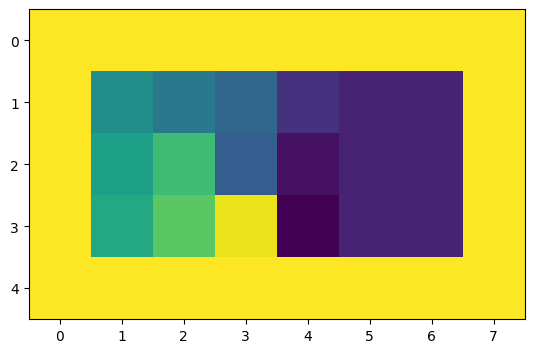

In [15]:
state_value = torch.zeros(lenS)
for s in range(lenS):
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(model(state))


Value_matrix_plot = np.zeros(env.maze.shape)
for s, state in enumerate(states):
    if state[1] == (1,1):
        Value_matrix_plot[state[0][0],state[0][1]] = state_value[s]

plt.imshow(Value_matrix_plot)
Value_matrix_plot


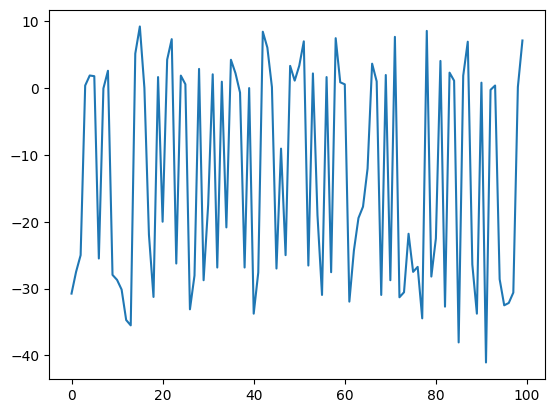

In [16]:
def evaluate_network(env : GridEnvDeform, model, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = torch.argmax(model(state))
            next_state, reward, done, _, info = env.step(action.item(),s)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)


            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

rewards = [evaluate_network(env, model, 10) for _ in range(100)]
plt.plot(rewards)


In [17]:
evaluate_network(env, model, 1000)

np.float64(-4.746497373029772)

# train dqn 
optionally start with a pretrained model 

In [18]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(state)
            next_state, reward, done, _, info = env.step(action,s)

            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)


            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward


In [19]:
state_dim = 5
action_dim = 4

agent = DoubleDQNAgent(state_dim, action_dim, lr = 0.01, q_network=model)

env_wrapper = POMDPWrapper_v0(env, agent, T, O, R)

In [20]:
num_episodes = 200

rewards = []
evalrewards = []

for episode in trange(num_episodes):
    #
    #state, _ = env_wrapper.reset()
    
    # when bypassing the wrapper, we need to convert the state to the actual state
    s, _ = env.reset()
    state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

    
    episode_reward = 0
    done = False
    
    steps = 0
    while not done:
        action = agent.choose_action(state)
        
        # obs, reward, done, info = env_wrapper.step(state, action)
        # next_state = info['actual_state']
        # agent.store_transition([state], action, reward, [next_state], done)
        
        # bypassing the wrapper to get the actual state should be equilvalent to the above
        # remember to reset the environment with the actual state and not the wrapper 
        s_ , reward, done , _, _ = env.step(action,s, execute=True)
        next_state = torch.tensor([item for sublist in s_ for item in sublist], dtype=torch.float32)
        agent.store_transition(state, action, reward, next_state, done)

        agent.train()
        state = next_state
        episode_reward += reward
        steps += 1        
        if done or steps > 200:
            agent.update_epsilon()
            rewards.append(episode_reward)
            # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}, Epsilon: {agent.epsilon:.2f}")
            break
    
    if episode != 0 and episode % 5 == 0:
        avg_reward = evaluate_agent_training(env, agent)
        evalrewards.append(avg_reward)
        # print(f"Episode {episode + 1}/{num_episodes}, Average Reward: {avg_reward}")

print("Training complete.")
print("evalrewards: ", evalrewards)

100%|██████████| 200/200 [01:49<00:00,  1.83it/s]

Training complete.
evalrewards:  [np.float64(3.127659574468085), np.float64(-19.3), np.float64(3.597826086956522), np.float64(-20.05), np.float64(-35.65), np.float64(-26.25), np.float64(0.5294117647058824), np.float64(0.8676470588235294), np.float64(-20.05), np.float64(-30.9), np.float64(-24.227272727272727), np.float64(-26.95), np.float64(-26.95), np.float64(-38.75), np.float64(-25.0), np.float64(-35.45), np.float64(-29.4), np.float64(-23.75), np.float64(-31.25), np.float64(-27.458333333333332), np.float64(7.405172413793103), np.float64(2.2058823529411766), np.float64(-32.55), np.float64(1.4705882352941178), np.float64(-18.6), np.float64(0.4696969696969697), np.float64(-26.25), np.float64(-0.7352941176470589), np.float64(-21.25), np.float64(-15.045454545454545), np.float64(-30.0), np.float64(-27.4), np.float64(-31.25), np.float64(10.61320754716981), np.float64(3.4558823529411766), np.float64(-30.0), np.float64(1.1029411764705883), np.float64(7.120689655172414), np.float64(6.9396551724

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        , -68.36141205, -70.22888184, -97.46875   ,
        -97.46875   , -97.46875   , -97.46875   ,   0.        ],
       [  0.        , -68.38664246, -68.46244049, -97.46875   ,
        -97.46875   , -97.46875   , -97.46875   ,   0.        ],
       [  0.        , -68.4081192 , -68.64591217, -80.5368576 ,
        -97.46875   , -97.46875   , -97.46875   ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

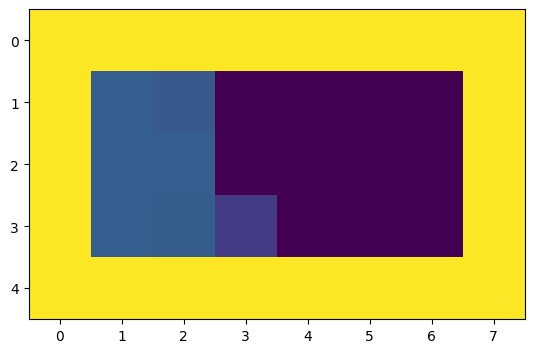

In [21]:
state_value = torch.zeros(lenS)
for s in range(lenS):
    state = torch.tensor([item for sublist in states[s] for item in sublist], dtype=torch.float32)
    state_value[s] = torch.max(agent.q_network(state))


Value_matrix_plot = np.zeros(env.maze.shape)
for s, state in enumerate(states):
    # print(f"State: {state}, Value: {state_value[s]}")
    if state[1] == (1,1):
        Value_matrix_plot[state[0][0],state[0][1]] = state_value[s]

plt.imshow(Value_matrix_plot)
Value_matrix_plot

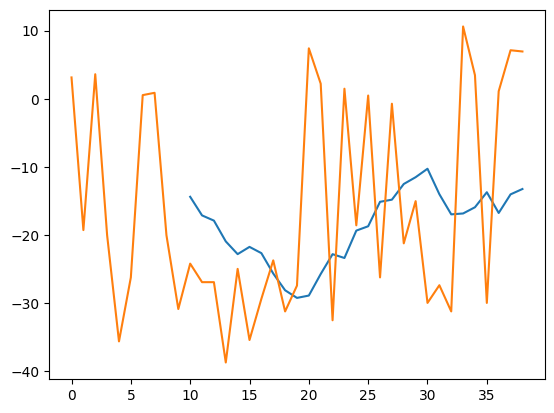

In [22]:
# plot evalrewards
rolling = [-np.inf for _ in range(10)] + [np.mean(evalrewards[i-10:i]) for i in range(10,len(evalrewards))]
plt.plot(rolling)
plt.plot(evalrewards)

In [23]:
evaluate_agent_training(env, agent, 1000)

np.float64(-6.366336633663367)

# rendered evaluation


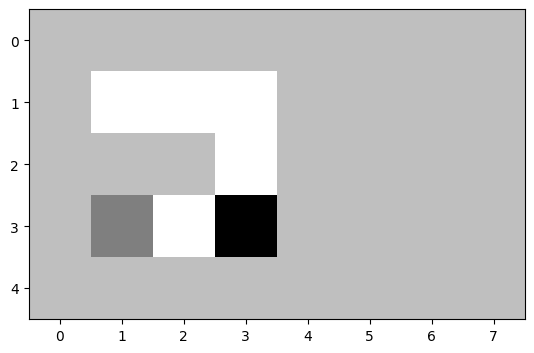

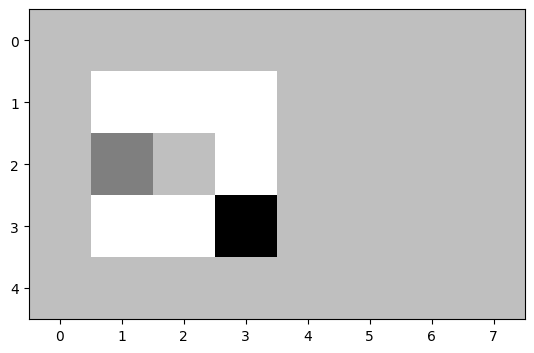

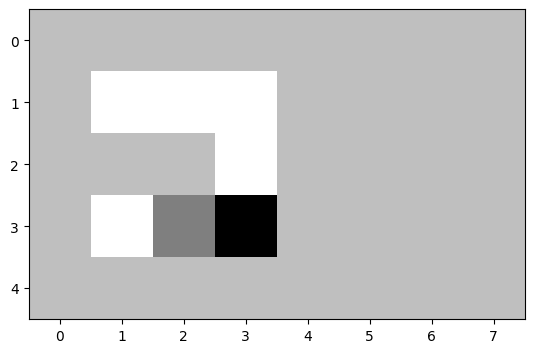

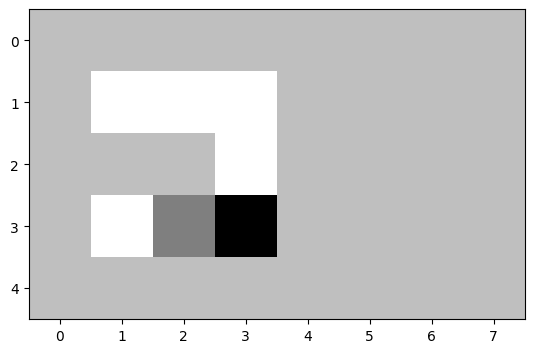

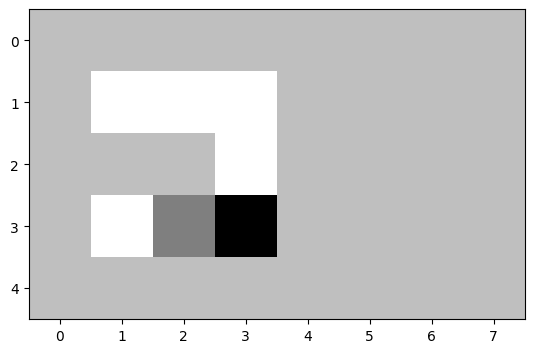

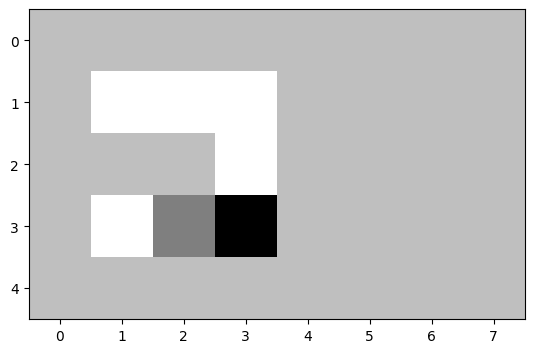

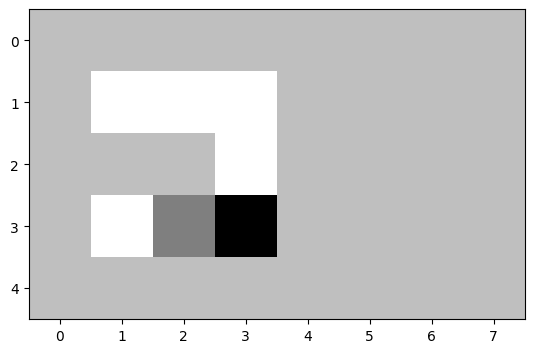

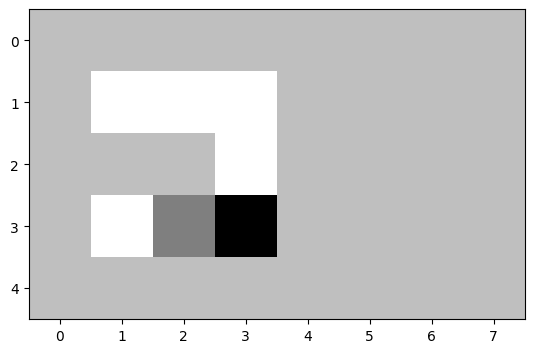

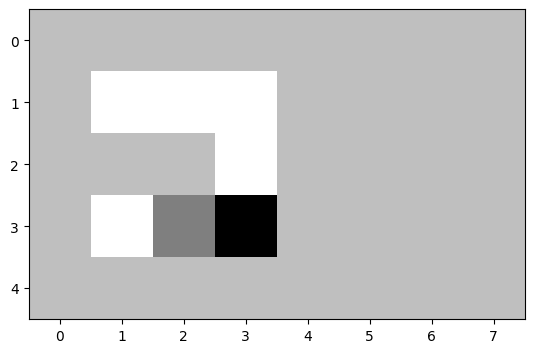

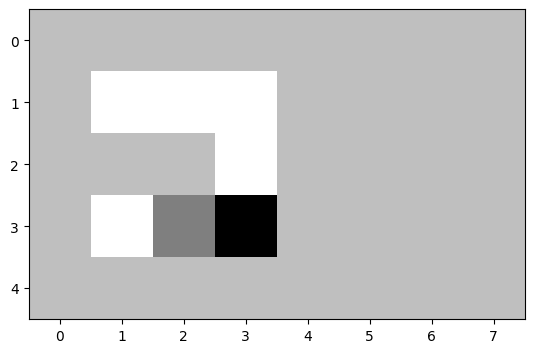

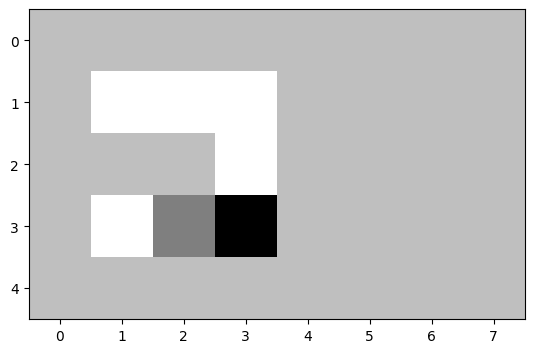

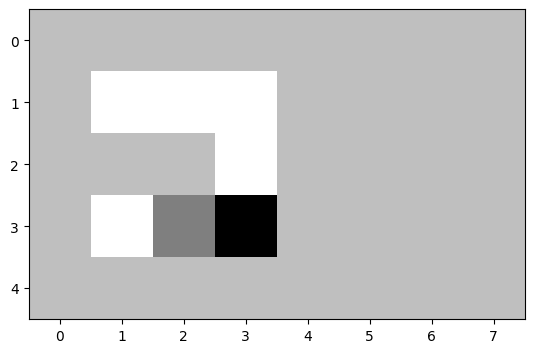

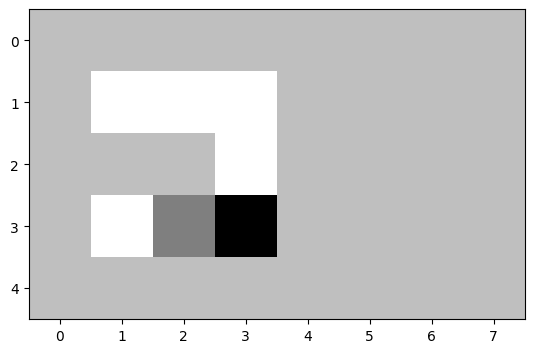

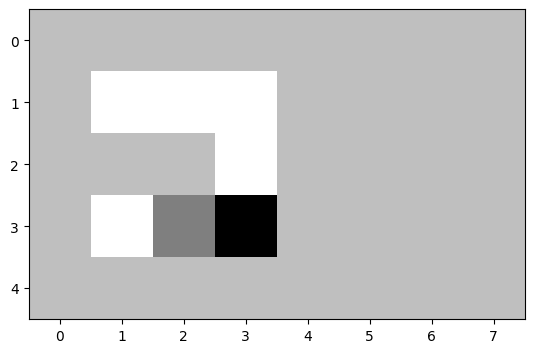

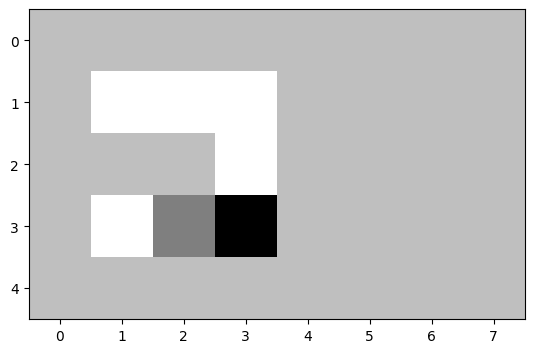

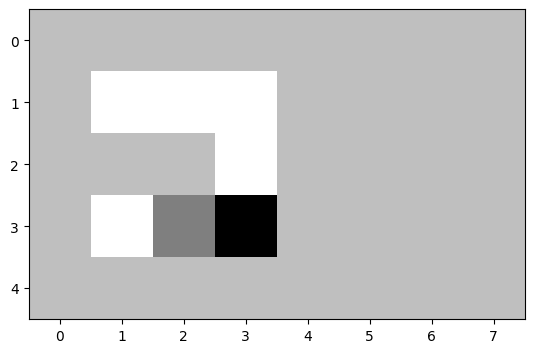

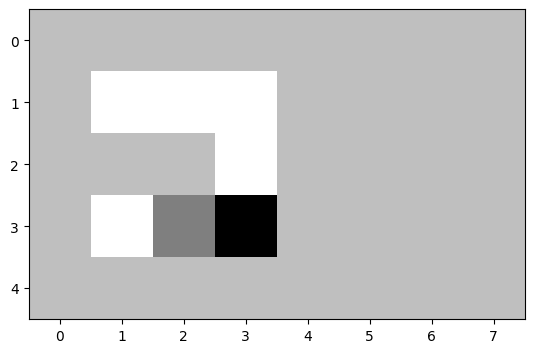

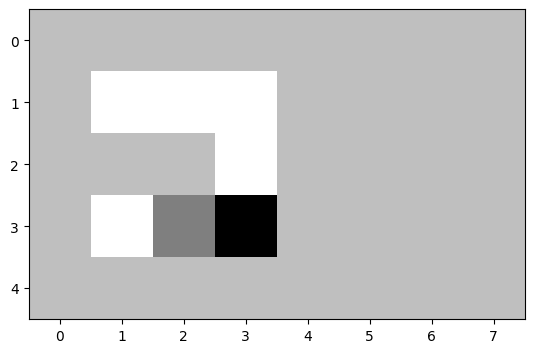

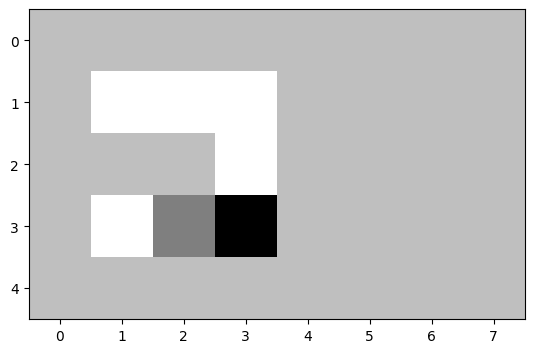

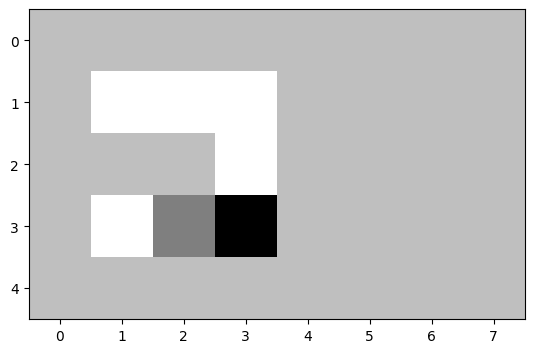

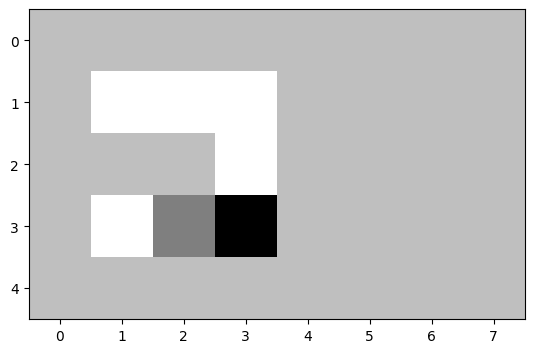

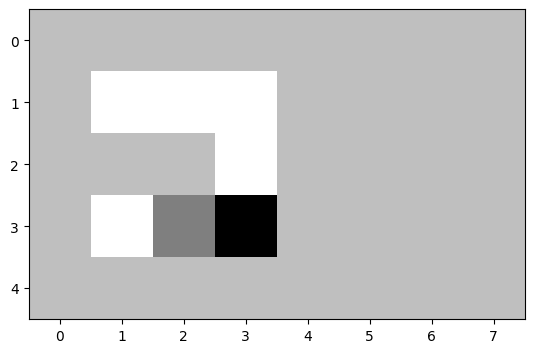

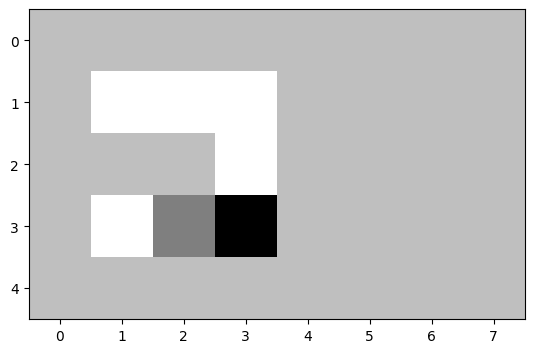

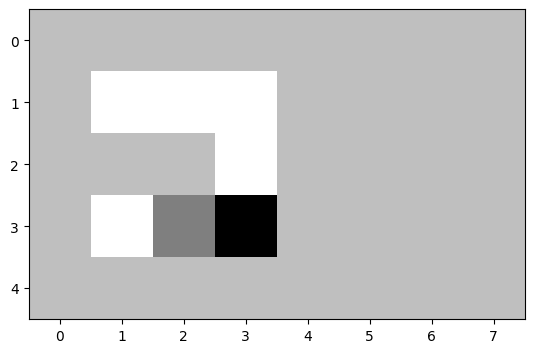

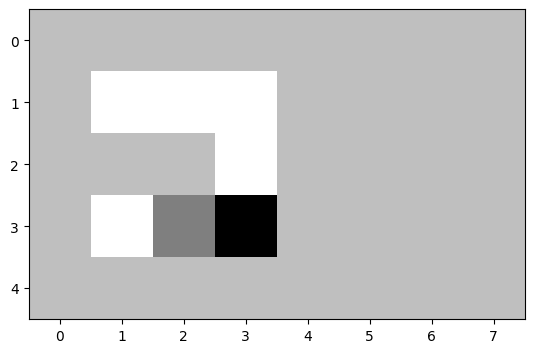

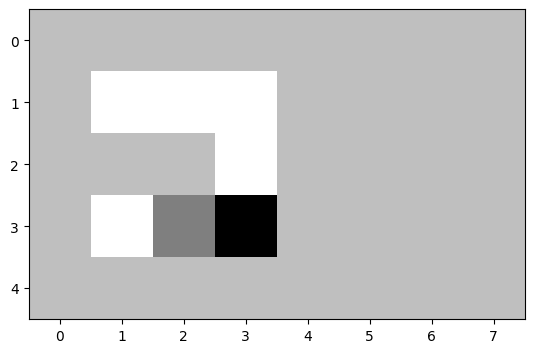

np.float64(-14.0)

In [31]:
import time 

def evaluate_agent(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        env.render()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)

        episode_reward = 0
        done = False
        c = 25
        while c > 0:
            # Render the environment
            # env.render()

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_action(state)
            next_state, reward, done, _, info = env.step(action,s, execute=True)
            env.render()
            state = torch.tensor([item for sublist in next_state for item in sublist], dtype=torch.float32)


            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
            time.sleep(0.1)
            
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward

evaluate_agent(env, agent, 1)


# transition check

In [9]:
# copy what is done in training:
# start from a random state chose an action and store the transition 
state, _ = env_wrapper.reset()
action = agent.choose_action([state])

obs, reward, done, info = env_wrapper.step(state, action)
next_state = info['actual_state'] # next true state (not observation or belief)

agent.store_transition([state], action, reward, [next_state], done)
state, action, reward, next_state, done


(109, 0, -1.0, 109, False)

((3, 2, 2), (2, 1))


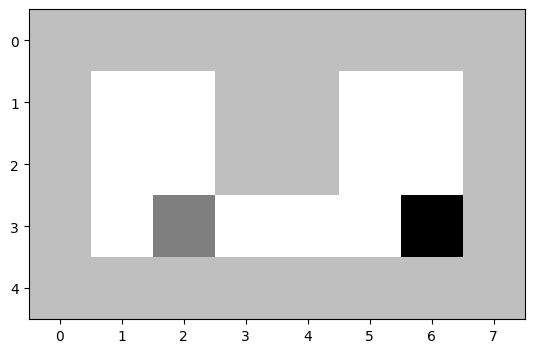

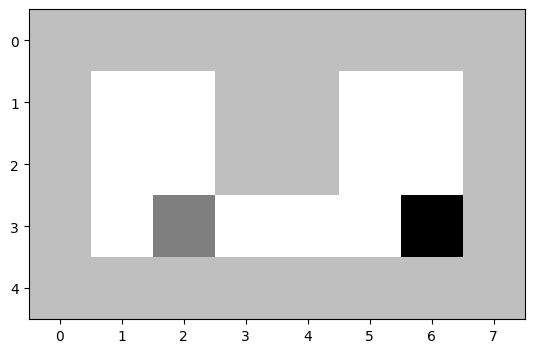

Training transition is correct


In [10]:
# set state and render
env.set_state(states[state])
print(states[state])
env.render()

# step and render
_ , _, _ , _, _ = env.step(action, states[state], execute=True)
env.render()

# check if the transition is correct
assert env.get_state() == states[next_state]
print("Training transition is", "correct" if env.get_state() == states[next_state] else "incorrect")

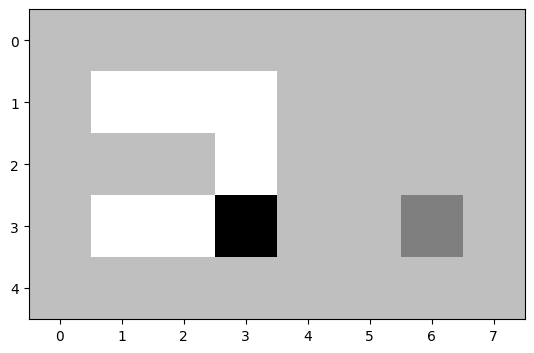

In [23]:
maze = create_maze(N)
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()